# Description of the problem and data

This project details participation in the Kaggle competition focused on binary classification of medical images. The images are derived from histopathologic scans of lymph node sections.

The dataset includes 220,000 labeled images and 57,000 unlabeled test images, with each image being a 96x96 RGB file in TIFF format.

Participants must develop models to accurately predict the presence of a tumor in the central 32x32 pixel region of the test images.

# Exploratory Data Analysis (EDA)

During the EDA phase, we examine the dataset, visualize the images, and assess the balance of true and false labels.

First, we upload the Kaggle authorization key required to download the datasets from Kaggle.

In [1]:
!ls -la
from google.colab import files
files.upload()

total 20
drwxr-xr-x 1 root root 4096 May 26 10:32 .
drwxr-xr-x 1 root root 4096 May 26 10:20 ..
drwxr-xr-x 4 root root 4096 May 23 13:19 .config
drwx------ 5 root root 4096 May 26 10:32 drive
drwxr-xr-x 1 root root 4096 May 23 13:20 sample_data


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artgourevitch","key":"b9f7abc86bcbc8c81fc98c3906168b74"}'}

Then we download and unzip the dataset images

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -q histopathologic-cancer-detection.zip


100% 6.28G/6.31G [00:26<00:00, 251MB/s]
100% 6.31G/6.31G [00:26<00:00, 252MB/s]


Import all the libraries

In [3]:
import numpy as np
import tensorflow as tf
import os
import keras
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50V2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Input
from keras.optimizers import Adam

We visually examine a small sample of the dataset images.

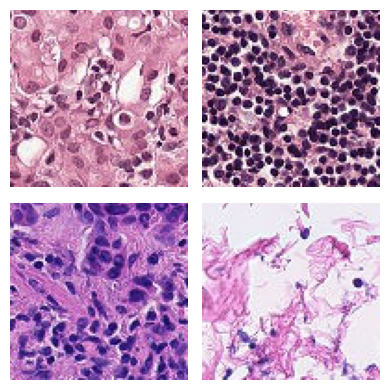

In [4]:
base_file_path = '/content'
label_path = f'{base_file_path}/train_labels.csv'
directory = f'{base_file_path}/train'

image_paths = ['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif','00004aab08381d25d315384d646f5ce413ea24b1.tif', '0000da768d06b879e5754c43e2298ce48726f722.tif','0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif']
images = [Image.open(directory + '/' + image_path) for image_path in image_paths]
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(4, 4))
axes = axes.flatten()
for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()
plt.show()

Next, we assess the balance between the 0 and 1 classes in the dataset, where the 1 class indicates the presence of a tumor in the central region of the image.

           id
label        
0      130908
1       89117


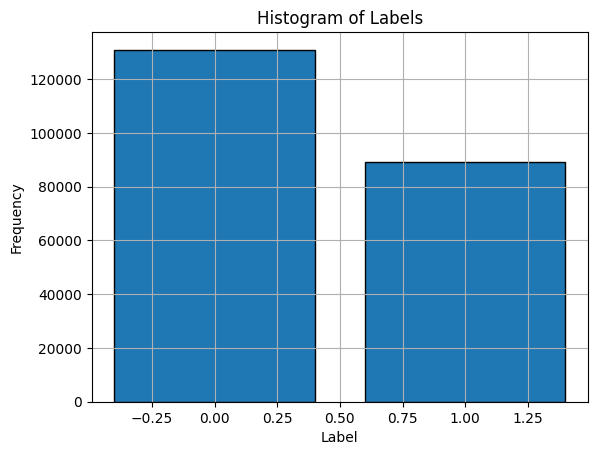

In [5]:


input_size = 1

df = pd.read_csv(label_path)
print(df.groupby('label').count())

df['label'].hist(bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.8)

plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.show()

We observe that the 0 class is slightly more prevalent, with a 60% ratio, which is sufficiently balanced for our use case.

Next we load the images split into training and validation datasets

In [6]:
'''
    Assuming the dataset is clean - it does not contain corrupted images
'''

df = pd.read_csv(label_path)
df['label_str'] = df['label'].astype(str)
df['id'] = df['id'] + '.tif'
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=1)

batch_size = 64
input_size = 0.1
epochs = 10
input_shape = (96, 96, 3)

steps_per_epoch = int(input_size * len(train_df) // batch_size)
validation_steps = int(input_size * len(valid_df) // batch_size)

train_datagen = ImageDataGenerator(rescale=1 / 255)
validation_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='id',
    y_col='label_str',
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode='categorical',
    target_size=(96, 96)
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=directory,
    x_col='id',
    y_col='label_str',
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode='categorical',
    target_size=(96, 96)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Modeling

During the modeling phase, we evaluate two different architectures.

The first is a basic CNN with 6 convolutional layers and 2 dense layers.

The second is a transfer learning model based on the pre-trained ImageNet50 model, which has 25 million parameters.

### Basic CNN architecture

We crop the input 96\*96 images and leave only central square of 36\*36 which is slightly larger than the target 32x32 image region to allow padding and some context.

Next, we add convolutional layers, each followed by normalization and ReLU activation layers. After every two layers, we perform 2x2 max pooling. The size of the convolutional layers gradually increases up to 128 filters.

The resulting model has 609,000 parameters, which is manageable and enables relatively fast training.

In [7]:
'''
    Building model
'''
model = keras.Sequential()
model.add(keras.Input(shape=(96, 96, 3)))
model.add(keras.layers.CenterCrop(36, 36))

for i in [32, 64, 128]:
    model.add(keras.layers.Conv2D(i, 3, padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))

    model.add(keras.layers.Conv2D(i, 3, padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))

    model.add(keras.layers.MaxPooling2D(2, strides=2, padding="same"))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(2, activation='softmax'))

keras.utils.plot_model(model, show_shapes=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 36, 36, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 36, 36, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 36, 36, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 32)        9248      
                                       

Then we fit the model over 4 epochs and save its weights. The training vs validation loss and accuracy are given below

Epoch 1/4
275/275 [==============================] - 27s 88ms/step - loss: 0.4824 - accuracy: 0.7768 - val_loss: 1.1905 - val_accuracy: 0.5363
Epoch 2/4
275/275 [==============================] - 24s 86ms/step - loss: 0.4531 - accuracy: 0.7945 - val_loss: 0.5559 - val_accuracy: 0.7293
Epoch 3/4
275/275 [==============================] - 24s 86ms/step - loss: 0.4368 - accuracy: 0.8023 - val_loss: 0.4329 - val_accuracy: 0.8045
Epoch 4/4
275/275 [==============================] - 24s 85ms/step - loss: 0.4335 - accuracy: 0.8038 - val_loss: 0.4100 - val_accuracy: 0.8127


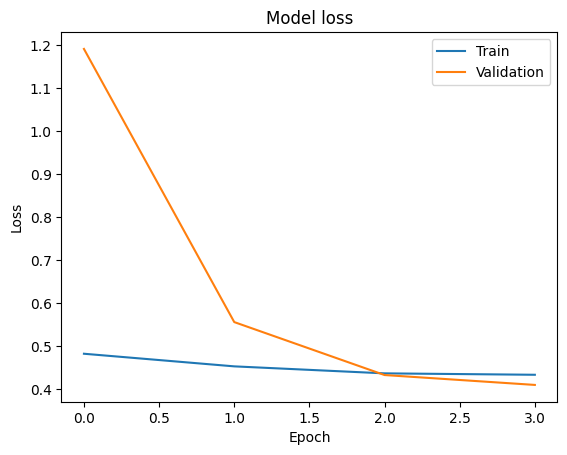

In [8]:
epochs = 4

# train the model on the new data for a few epochs
fitted_model = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)
model.save('model_cnn.keras')

plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The graph shows that the loss of the training set decreases gradually during the first two epochs and reaches stable zone afterwards. Hence there is no sense to continue training as the model enters the overfit zone.

# Transfer learning CNN architecture

The base model for transfer learning is ResNet50 having 50 deep
 convolutional layers trained on ImageNet data.

 ResNet50, (or Residual Network) has 50 layers, is a deep convolutional neural network architecture designed to address the vanishing gradient problem. Developed by Kaiming He and his colleagues at Microsoft Research, ResNet50 introduced the concept of residual learning, which helps in training very deep networks by allowing the model to learn residuals instead of direct mappings.

  We add 2 top layers of Dense network and train only those layers.

In [9]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

x = base_model.output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

print(f'{len(base_model.layers)} layers of the base model are frozen')

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
190 layers of the base model are frozen
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 50, 50, 64)           0         ['conv1_conv[0][0]']

Epoch 1/10
275/275 [==============================] - 67s 233ms/step - loss: 0.4614 - accuracy: 0.7830 - val_loss: 0.4124 - val_accuracy: 0.8169
Epoch 2/10
275/275 [==============================] - 63s 228ms/step - loss: 0.3895 - accuracy: 0.8250 - val_loss: 0.3833 - val_accuracy: 0.8265
Epoch 3/10
275/275 [==============================] - 62s 224ms/step - loss: 0.3715 - accuracy: 0.8359 - val_loss: 0.3634 - val_accuracy: 0.8419
Epoch 4/10
275/275 [==============================] - 63s 228ms/step - loss: 0.3615 - accuracy: 0.8406 - val_loss: 0.3830 - val_accuracy: 0.8385
Epoch 5/10
275/275 [==============================] - 62s 225ms/step - loss: 0.3474 - accuracy: 0.8472 - val_loss: 0.3522 - val_accuracy: 0.8396
Epoch 6/10
275/275 [==============================] - 61s 223ms/step - loss: 0.3421 - accuracy: 0.8523 - val_loss: 0.3694 - val_accuracy: 0.8415
Epoch 7/10
275/275 [==============================] - 61s 221ms/step - loss: 0.3212 - accuracy: 0.8596 - val_loss: 0.3600 - val_ac

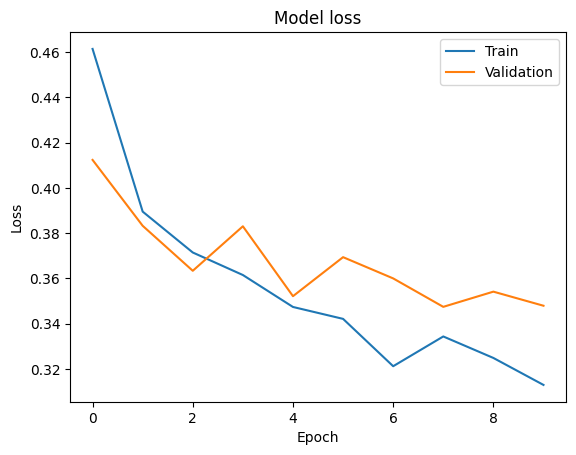

In [10]:


epochs = 10

fitted_model = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

model.save('model_transfer_learning.keras')

plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


After the top Dense layers are well trained, we retrain the whole huge model. The training takes a lot of computational resources as the model has 22M parameters.

Epoch 1/10
275/275 [==============================] - 228s 778ms/step - loss: 0.3854 - accuracy: 0.8330 - val_loss: 0.3658 - val_accuracy: 0.8545
Epoch 2/10
275/275 [==============================] - 207s 751ms/step - loss: 0.3035 - accuracy: 0.8744 - val_loss: 0.2918 - val_accuracy: 0.8851
Epoch 3/10
275/275 [==============================] - 208s 756ms/step - loss: 0.2556 - accuracy: 0.8952 - val_loss: 0.2784 - val_accuracy: 0.8934
Epoch 4/10
275/275 [==============================] - 208s 758ms/step - loss: 0.2417 - accuracy: 0.9059 - val_loss: 0.2555 - val_accuracy: 0.8973
Epoch 5/10
275/275 [==============================] - 207s 752ms/step - loss: 0.2158 - accuracy: 0.9151 - val_loss: 0.1914 - val_accuracy: 0.9242
Epoch 6/10
275/275 [==============================] - 205s 743ms/step - loss: 0.1912 - accuracy: 0.9274 - val_loss: 0.2114 - val_accuracy: 0.9182
Epoch 7/10
275/275 [==============================] - 205s 744ms/step - loss: 0.1816 - accuracy: 0.9300 - val_loss: 0.1999 -

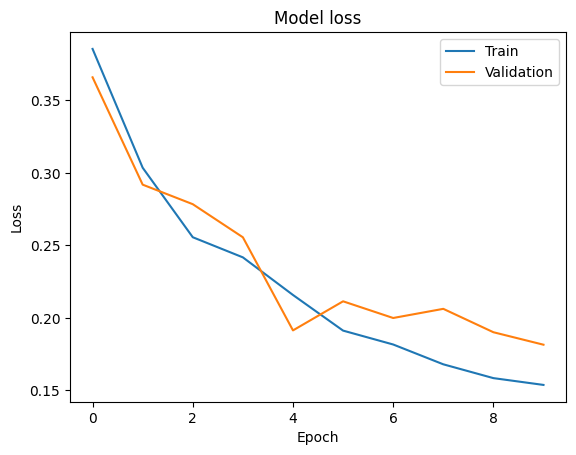

In [11]:
base_model.trainable = True
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

epochs = 10

# Train the model on the new data for a few epochs
fitted_model = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

model.save('model_transfer_learning.keras')

plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Results and Analysis

During transfer learning approach the loss gradually decrease and accuracy on the validation dataset reaches 0.93. At this point we stop the learning, generate test labels and submit to Kaggle.  

## Submission to Kaggle

During result evaluation phase we create a submission csv file by predicting the labels on test dataset.

First, the folder structure under test folder should be slightly changed.

In [12]:
!rm -fr /content/test_1/0/
! mkdir -p /content/test_1/0
!ls -la /content/test_1/0/
!rsync -a /content/test/ /content/test_1/0/

! ls -la /content/test_1/0 | wc -l
! ls -la /content/test/ | wc -l

total 8
drwxr-xr-x 2 root root 4096 May 26 11:22 .
drwxr-xr-x 3 root root 4096 May 26 11:22 ..
57461
57461


The class with the highest probability is chosen.

In [13]:
#model = keras.saving.load_model('model_cnn.keras')
#model = keras.saving.load_model('model_transfer_learning.keras')

test_directory = f'{base_file_path}/test_1'

test_datagen = ImageDataGenerator(rescale=1 / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_directory,
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode=None,  # No labels since we're predicting
    shuffle=False  # Do not shuffle the data for consistent predictions
)

predictions = model.predict(test_generator, steps=len(test_generator))

predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes[:10])


filenames = test_generator.filenames

results = list(zip(filenames, predicted_classes))

res = ['id,label\n']
for filename, predicted_class in results:
    res.append(f'{filename[2:-4]},{predicted_class}\n')

from datetime import datetime
now = datetime.now()
formatted_date_time = now.strftime("%Y_%m_%d_%H_%M_%S")

with open(f"{base_file_path}/test_labels_{formatted_date_time}.csv", 'w') as file:
    file.writelines(res)




Found 57458 images belonging to 1 classes.
898/898 [==============================] - 150s 166ms/step
[1 1 1 0 0 0 0 1 0 1]


The submission achieved a public score of 0.876 and a private score of 0.83.

The lower score assigned by Kaggle compared to the validation accuracy suggests that the loss function and metric used in training may not accurately reflect Kaggle's evaluation metric.









# Conclusion


In this project, we addressed the binary image classification of medical images. We compared two approaches: a straightforward CNN architecture and transfer learning using ResNet50.

Transfer learning yielded more accurate predictions, achieving a public score of 0.876 and a private score of 0.83.

Enhancing the training process with more computational power is expected to further improve accuracy. Additionally, other models can be explored as base models for transfer learning.
